# Document Clustering using LLM / Sentence-Transformer Embeddings

This notebook clusters documents using state-of-the-art embeddings (sentence-transformers). It demonstrates loading a corpus (20 Newsgroups), computing embeddings, reducing dimensionality (UMAP), clustering (HDBSCAN/KMeans), and evaluating clusters with silhouette and representative documents per cluster.

# Install notes (Colab)
# !pip install sentence-transformers umap-learn hdbscan scikit-learn

print('Uncomment pip installs when running in Colab if packages missing')

In [3]:
# Imports and dataset (20 Newsgroups)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

sns.set()

print('Loading 20 Newsgroups subset...')
cats = ['talk.politics.misc','rec.autos','sci.space','comp.graphics']
newsgroups = fetch_20newsgroups(subset='train', categories=cats, remove=('headers','footers','quotes'))
docs = newsgroups.data[:1000]
labels_true = newsgroups.target[:1000]
print('Loaded', len(docs), 'documents')


Loading 20 Newsgroups subset...
Loaded 1000 documents


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters found (HDBSCAN): [-1  0  1]
Silhouette (ignoring noise): 0.048091415


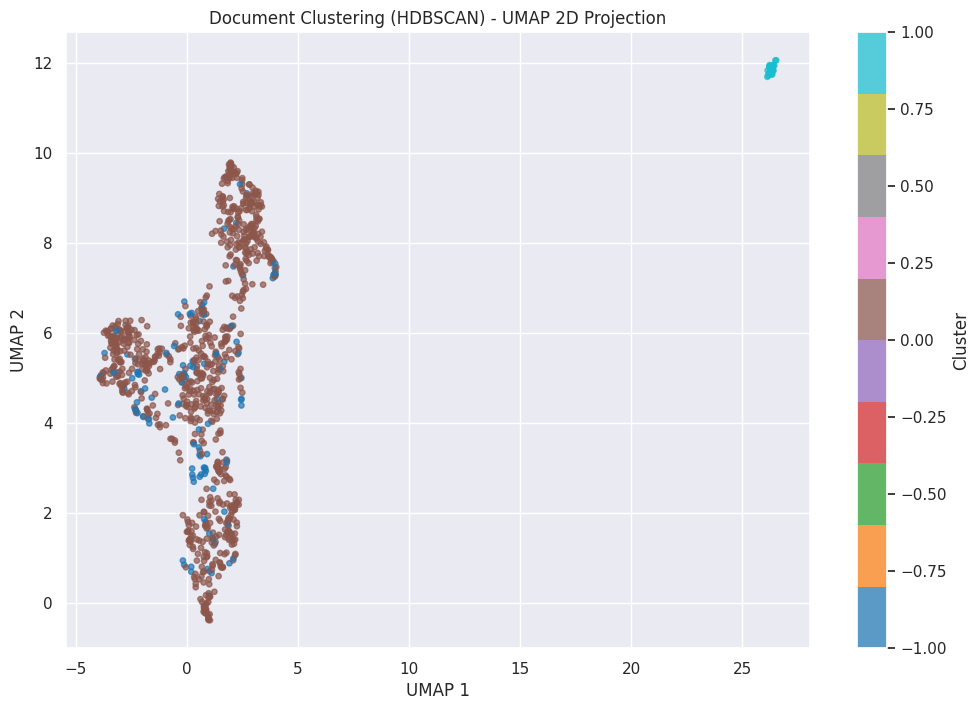

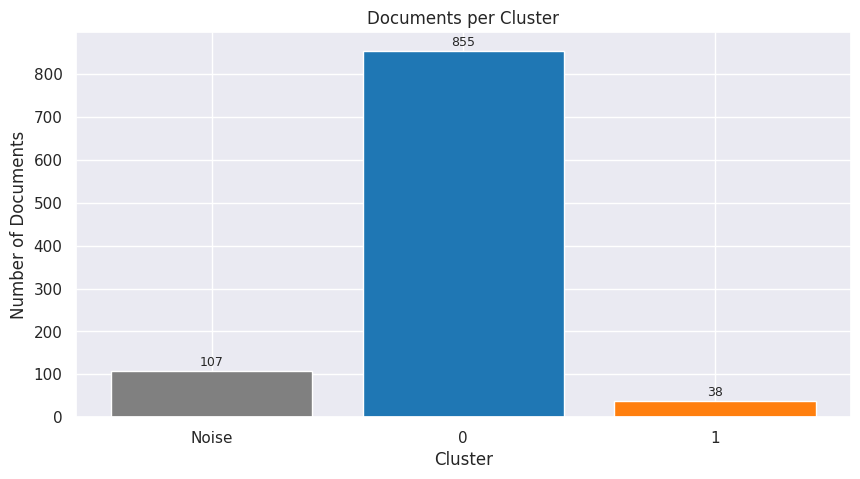

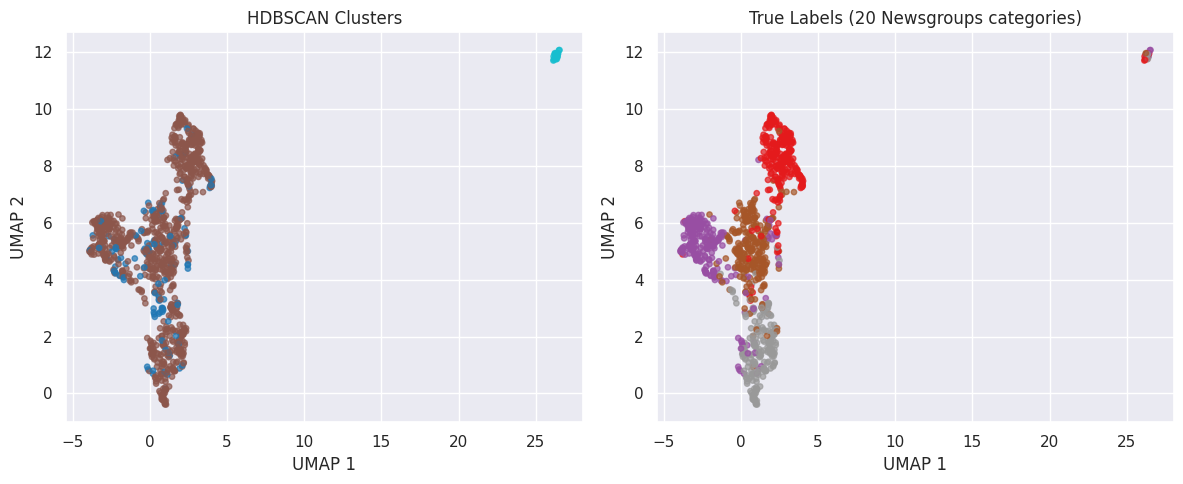

Adjusted Rand Index (HDBSCAN vs true): 0.0019639668419644592
Cluster 0: size=855 example doc excerpt:
 COMMERCIAL SPACE NEWS/SPACE TECHNOLOGY INVESTOR NUMBER 22     This is number twenty-two in an irregular series on commercial  space activities.  The commentaries included are my thoughts on  these developments.       Sigh... as usual, I've gotten beh
---
Cluster 1: size=38 example doc excerpt:
  
---


In [4]:
# Compute embeddings with sentence-transformers (small model) and cluster
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(docs, show_progress_bar=True, batch_size=64)

# Reduce with UMAP and cluster with HDBSCAN
reducer = umap.UMAP(n_components=2, random_state=42)
emb_2d = reducer.fit_transform(embeddings)
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
cluster_labels = clusterer.fit_predict(embeddings)

print('Clusters found (HDBSCAN):', np.unique(cluster_labels))
non_noise_mask = cluster_labels != -1
if non_noise_mask.sum() > 1:
    print('Silhouette (ignoring noise):', silhouette_score(embeddings[non_noise_mask], cluster_labels[non_noise_mask]))

# --- Visualization: 2D UMAP scatter plot colored by cluster ---
plt.figure(figsize=(12, 8))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=cluster_labels, cmap='tab10', s=15, alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title('Document Clustering (HDBSCAN) - UMAP 2D Projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# --- Visualization: Cluster distribution bar chart ---
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
plt.figure(figsize=(10, 5))
colors = ['gray' if l == -1 else plt.cm.tab10(l % 10) for l in unique_labels]
bars = plt.bar([str(l) if l != -1 else 'Noise' for l in unique_labels], counts, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Number of Documents')
plt.title('Documents per Cluster')
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, str(count), ha='center', va='bottom', fontsize=9)
plt.show()

# --- Visualization: Compare to true labels (if available) ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=cluster_labels, cmap='tab10', s=15, alpha=0.7)
plt.title('HDBSCAN Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels_true, cmap='Set1', s=15, alpha=0.7)
plt.title('True Labels (20 Newsgroups categories)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.show()

# ARI between predicted clusters and true labels
print('Adjusted Rand Index (HDBSCAN vs true):', adjusted_rand_score(labels_true, cluster_labels))

# Show sample representative docs per non-noise cluster
from sklearn.metrics.pairwise import cosine_similarity
for cl in np.unique(cluster_labels):
    if cl == -1:
        continue
    idx = np.where(cluster_labels==cl)[0]
    centroid = embeddings[idx].mean(axis=0, keepdims=True)
    sims = cosine_similarity(centroid, embeddings[idx]).reshape(-1)
    rep = idx[np.argmax(sims)]
    print(f'Cluster {cl}: size={len(idx)} example doc excerpt:\n', docs[rep][:250].replace('\n',' '))
    print('---')